In [1]:
# data manipulation
import pandas as pd
import numpy as np
import math
# visualization
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from datetime import datetime
# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
import lightgbm as lgb
from datetime import datetime
# ignore warnings
import warnings
from sklearn.ensemble import VotingClassifier
warnings.filterwarnings('ignore')

In [2]:
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from dateutil.parser import parse

In [3]:
showimage=True

In [4]:
dfy=pd.read_csv("Ytrain.csv")
dfy = dfy.drop(['Id'], 1)
dfy.columns=['Y']

In [5]:
dfx=pd.read_csv("Xtrain.csv")

In [6]:
df = pd.concat([dfx, dfy], axis=1)

In [7]:
#df = pd.read_csv("Xtest.csv")

In [8]:
df.head()

,Id,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Y
0,0,"NPE Realty, LLC",Pembroke Pines,FL,33027,"TD BANK, NATIONAL ASSOCIATION",DE,334516,16-Apr-10,2010,...,0,1,N,N,1-May-10,"$2,000,000.00",$0.00,"$2,000,000.00","$1,500,000.00",0
1,1,"KEVCO CONSTRUCTION, LLC",SANDY,UT,84094,ZIONS FIRST NATIONAL BANK,UT,236115,30-Jan-10,2010,...,0,1,N,N,1-Feb-10,"$17,000.00",$0.00,"$17,000.00","$17,000.00",1
2,2,EAST L A SHOE REPAIR,LOS ANGELES,CA,90022,BANK OF AMERICA NATL ASSOC,NC,811430,29-Jul-02,2002,...,1,1,Y,N,31-Aug-02,"$17,000.00",$0.00,"$17,000.00","$8,500.00",0
3,3,"RUSSLER, DANIEL C, MD",LODI,WI,53555,ASSOCIATED BANK NATL ASSOC,WI,0,10-Jun-94,1994,...,1,0,N,N,31-Jul-94,"$137,000.00",$0.00,"$137,000.00","$123,300.00",0
4,4,AFFORDABLE FAMILY DENISTRY LLC,LEBANON,MO,65536,COMMERCE BANK,MO,621210,6-Feb-06,2006,...,1,1,T,N,31-Mar-06,"$46,665.00",$0.00,"$25,000.00","$12,500.00",0


In [9]:
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)
state=df["Zip"][(df["State"].isna())].apply(lambda x:search.by_zipcode(x).state)
print(state)
df["State"][(df["State"].isna())]=state

Series([], Name: Zip, dtype: int64)


In [10]:
df["LowDoc"][(df["LowDoc"].notna()) & (df["LowDoc"]!='Y')]='N'
df["LowDoc"][df["LowDoc"].isna()]='nan'

df["RevLineCr"][(df["RevLineCr"].notna()) & (df["RevLineCr"]!='Y')]='N'
df["RevLineCr"][df["RevLineCr"].isna()]='nan'

In [11]:
np.sum(df["DisbursementDate"].isna()),np.sum(df["ApprovalDate"].isna()),

(119, 0)

In [12]:
import datetime

In [13]:
def parsedate(x):
    dt=parse(x)
    d=(dt-parse('19-Oct-20')).days
    if(d>=0):
        dt=datetime.datetime(dt.year-100,dt.month,dt.day)
    return dt

In [14]:
DisbursementDate = \
df['DisbursementDate'][df["DisbursementDate"].notna()].\
apply(lambda x: parsedate(x))

ApprovalDate = \
df['ApprovalDate'][df["DisbursementDate"].notna()].\
apply(lambda x: parsedate(x))

In [15]:
difdays=(DisbursementDate-ApprovalDate).apply(lambda x: x.days)
mdifdays=difdays.median()
print('mdifdays',mdifdays)

mdifdays 47.0


In [16]:
disDatenan = \
df['ApprovalDate'][df["DisbursementDate"].isna()].\
apply(lambda x: parse(x)+datetime.timedelta(days=mdifdays))

df['DisDate']=parse('19-Oct-21')
df['DisDate'][df["DisbursementDate"].isna()]=disDatenan
df['DisDate'][df["DisbursementDate"].notna()]=DisbursementDate

In [17]:
assert np.sum((df['DisDate']-parse('19-Oct-20')).apply(lambda x:x.days)>=0)==0

In [18]:
df['ApprovalDate'] = df['ApprovalDate'].apply(lambda x: parsedate(x))

In [19]:
df['before']=((parse("01-Dec-2007")>df['DisDate'])).astype(int)
df['recession']=((parse("01-Dec-2007")<=df['DisDate']) & \
                 (df['DisDate']<=parse("30-Jun-2009"))).astype(int)
#df['nowadays']=((parse("01-Sep-2010")<=df['DisDate'])).astype(int)
df['nowadays']=((parse("30-Jun-2009")<=df['DisDate'])).astype(int)

In [20]:
basedate=parse("20-Sep-1968")

df['Appday']=(df['ApprovalDate']-basedate).apply(lambda x:x.days)

df['Disday']=(df['DisDate']-basedate).apply(lambda x:x.days)

In [21]:
df['difday']=df['Disday']-df['Appday']

In [22]:
df.drop(['DisbursementDate','DisDate','ApprovalDate','ApprovalFY','Disday'],axis=1,inplace=True)

In [23]:
dollor=['DisbursementGross','GrAppv','SBA_Appv']
for i in dollor:
    df[i]=df[i].apply(str)
    df[i]=df[i].str.strip("$")
    df[i]=df[i].str.replace(",","") 
    df[i]=df[i].str.replace(".","") 
    df[i]=df[i].astype(int)//100

In [24]:
df['dif']=df['GrAppv']-df['SBA_Appv']

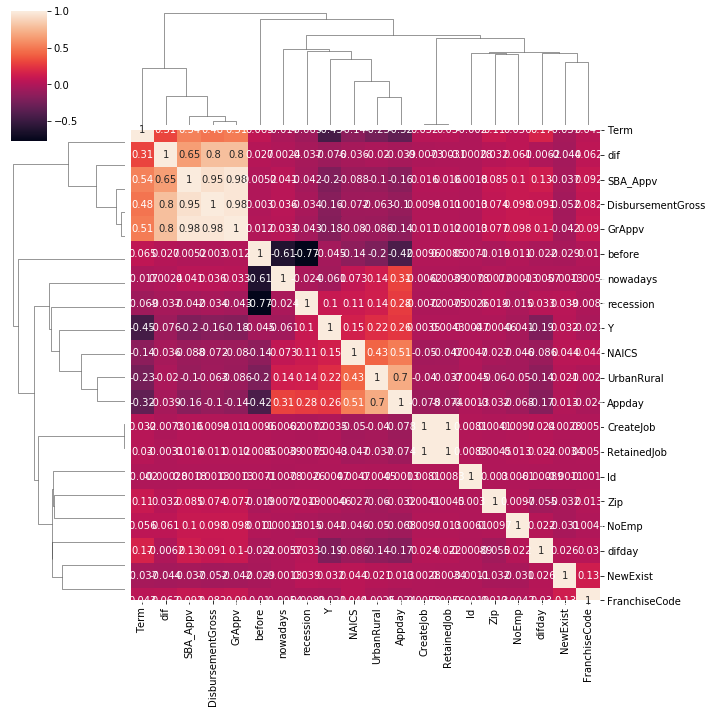

In [25]:
if showimage:
    sb.clustermap(df.corr(), annot=True)
    plt.show()

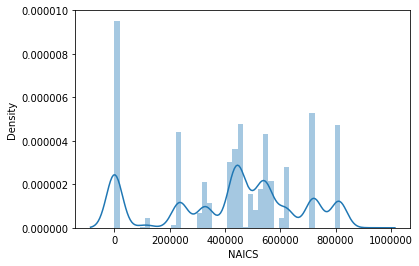

In [168]:
if showimage:
    sb.distplot(df["NAICS"])
    plt.show()

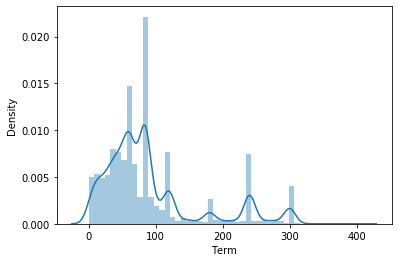

In [169]:
#df["NoEmp"]=np.log(1+df["NoEmp"])
if showimage:
    sb.distplot(df["Term"])
    plt.show()

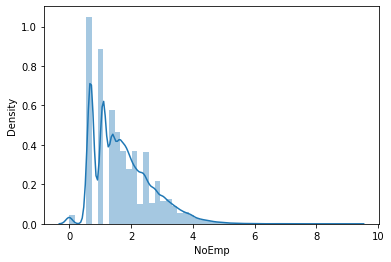

In [170]:
df["NoEmp"]=np.log(1+df["NoEmp"])
if showimage:
    sb.distplot(df["NoEmp"])
    plt.show()

In [171]:
print(np.sum(df['NewExist'].isna()))
df['NewExist'][df['NewExist'].isna()]=0

7


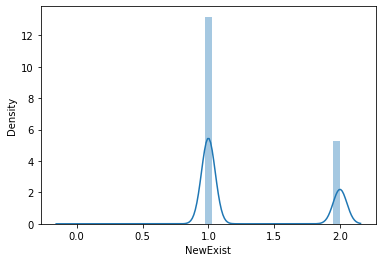

In [172]:
if showimage:
    sb.distplot(df["NewExist"])
    plt.show()

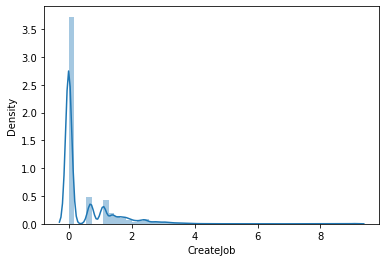

In [173]:
df["CreateJob"]=np.log(1+df["CreateJob"])
if showimage:
    sb.distplot(df["CreateJob"])
    plt.show()

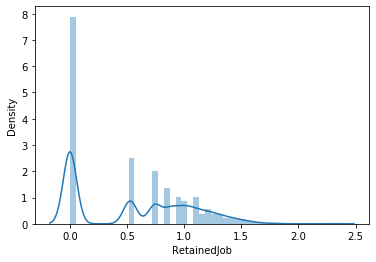

In [174]:
df["RetainedJob"]=np.log(1+df["RetainedJob"])
if showimage:
    sb.distplot(np.log(1+df["RetainedJob"]))
    plt.show() 

In [175]:
np.sum((df["UrbanRural"]==0)|(df["UrbanRural"]==1)|(df["UrbanRural"]==2))

50000

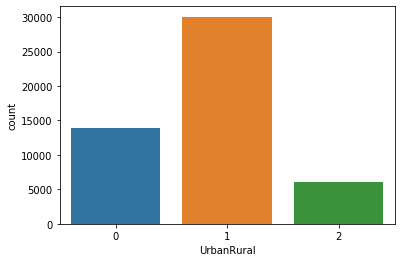

In [176]:
if showimage:
    sb.countplot(x ='UrbanRural', data = df) 
    plt.show() 

In [177]:
#df[df.FranchiseCode>1].FranchiseCode=2

In [178]:
print(np.sum(~df['FranchiseCode'].isin(['0','1'])))
#df['FranchiseCode'][df['FranchiseCode']==1]=0
df['FranchiseCode'][~df['FranchiseCode'].isin(['0','1'])]=2

2725


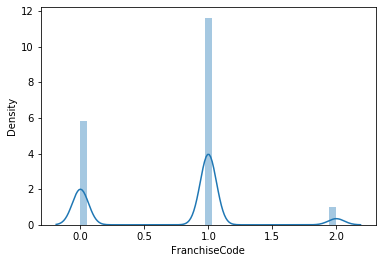

In [179]:
if showimage:
    sb.distplot(df["FranchiseCode"])
    plt.show()

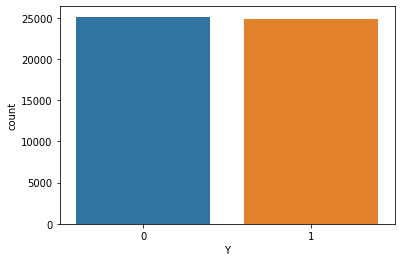

In [180]:
if showimage and 'Y' in df.columns.values:
    sb.countplot(x ='Y', data = df) 
    plt.show() 

In [181]:
df['EMI'] = df['DisbursementGross'].astype(float) / (df['Term']+1)

df['SequBS']=(df['State']==df['BankState']).astype(int)

df['portion']=df['SBA_Appv']/df['GrAppv']

df['realstate']=(df['Term']>240).astype(int)

In [182]:
nai={11:'Agriculture',21:'Mining',22:'Utilities',23:'Construction',31:'Manufacturing',
     32:'Manufacturing',
     33:'Manufacturing',42:'Wholesale',44:'Retail',45:'Retail',48:'Transportation',
     49:'Transportation',51:'Information',52:'Finance',53:'Real estate',
     54:'Professional',55:'Management',56:'Administrative',61:'Educational',
     62:'Health',71:'Arts',72:'Accommodation',81:'Other',92:'Public'
     }
def NAICS(a):
    if(int(a)//10000 in nai):return nai[int(a)//10000]
    return "no"
df['NAICS2'] = df.apply(lambda row: NAICS(row['NAICS']), axis=1)

# print(np.sum(df['NAICS2']=='no'))

# for i,j in nai.items():
#     print(j,np.sum(df['NAICS2']==j))

In [183]:
# for i in df.columns:
#     print(i,df[i].nunique())

In [184]:
df = df.drop(['Bank','Name','City','Zip','BalanceGross','Id'], 1)

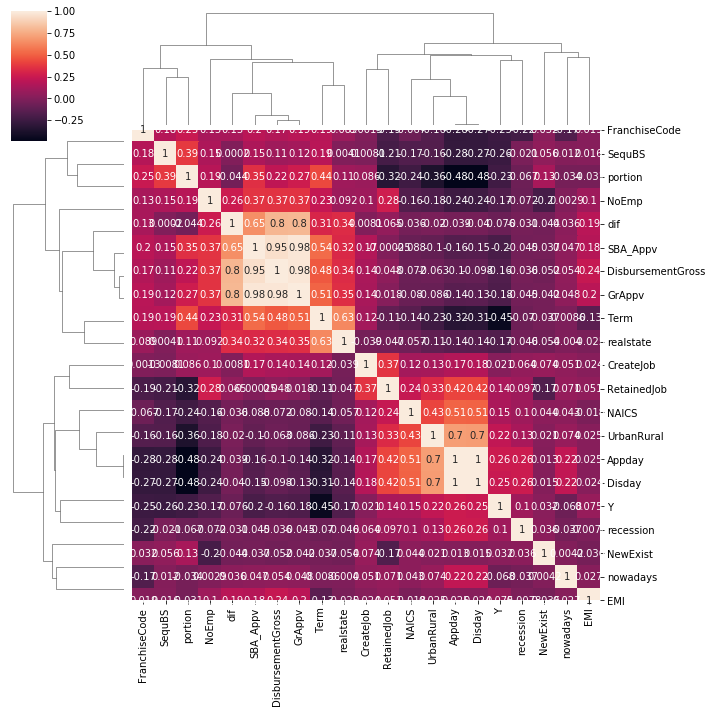

In [185]:
if showimage:
    sb.clustermap(df.corr(), annot=True)
    plt.show()

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 26 columns):
State                50000 non-null object
BankState            49923 non-null object
NAICS                50000 non-null int64
Term                 50000 non-null int64
NoEmp                50000 non-null float64
NewExist             50000 non-null float64
CreateJob            50000 non-null float64
RetainedJob          50000 non-null float64
FranchiseCode        50000 non-null int64
UrbanRural           50000 non-null int64
RevLineCr            50000 non-null object
LowDoc               50000 non-null object
DisbursementGross    50000 non-null int64
GrAppv               50000 non-null int64
SBA_Appv             50000 non-null int64
Y                    50000 non-null int64
recession            50000 non-null int64
nowadays             50000 non-null int64
Appday               50000 non-null int64
Disday               50000 non-null int64
dif                  50000 non-null int

In [187]:
tostr = ['FranchiseCode', 'NewExist', 'UrbanRural', 'State', 'BankState', 'RevLineCr',
         'LowDoc','NAICS2']
extra=[]
noneedforonehot=['nowadays','recession','realstate','SequBS']
for i in tostr:
    df[i]=df[i].astype(str)

In [188]:
df=pd.get_dummies(df)

In [189]:
df.head()

,NAICS,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,GrAppv,SBA_Appv,Y,recession,...,NAICS2_Mining,NAICS2_Other,NAICS2_Professional,NAICS2_Public,NAICS2_Real estate,NAICS2_Retail,NAICS2_Transportation,NAICS2_Utilities,NAICS2_Wholesale,NAICS2_no
0,334516,130,3.258097,1.098612,0.000000,2000000,2000000,1500000,0,0,...,0,0,0,0,0,0,0,0,0,0
1,236115,33,1.945910,0.693147,1.386294,17000,17000,17000,1,0,...,0,0,0,0,0,0,0,0,0,0
2,811430,60,0.693147,0.693147,0.693147,17000,17000,8500,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,160,0.693147,0.000000,0.000000,137000,137000,123300,0,0,...,0,0,0,0,0,0,0,0,0,1
4,621210,101,1.098612,2.079442,1.098612,46665,25000,12500,0,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 158 entries, NAICS to NAICS2_no
dtypes: float64(5), int64(13), uint8(140)
memory usage: 13.5 MB


In [191]:
df.columns.values

array(['NAICS', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob',
       'DisbursementGross', 'GrAppv', 'SBA_Appv', 'Y', 'recession',
       'nowadays', 'Appday', 'Disday', 'dif', 'EMI', 'SequBS', 'portion',
       'realstate', 'State_AK', 'State_AL', 'State_AR', 'State_AZ',
       'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE',
       'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID',
       'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA',
       'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN',
       'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND',
       'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV',
       'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA',
       'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX',
       'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI',
       'State_WV', 'State_WY', 'BankState_AK', 'BankState_AL',
       'BankState_AR', 'BankState_AZ', 'BankState_CA', 'BankSta

In [56]:
X=df.loc[:, df.columns != 'Y'].values
Y=df['Y'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=0)

KeyError: 'Y'

In [ ]:
clf = RandomForestClassifier(n_estimators=800,random_state=0)
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
acc = round(accuracy_score(y_test, y_pred) * 100, 2)
acc,round(accuracy_score(clf.predict(x_train), y_train) * 100, 2)

In [ ]:
import catboost as cb

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
xgbparams = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [10,20,30,40,50],
#     'reg_alpha': [1.1, 1.2, 1.3],
#     'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9],
    "min_child_weight" : [1,3,6],
    "learning_rate": [0.05, 0.1,0.16]
}

In [ ]:
lgbparam_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    "num_leaves": [50,100,200,300,900,1200],
#     'reg_alpha': [1.1, 1.2, 1.3],
#     'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}
#lgbm=pipeline(model,lgbparam_grid)

In [ ]:
cbparams = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300,500]}

In [ ]:
models = [
    XGBClassifier(objective='binary:logistic', silent=True, nthread=2, seed=0, verbosity=0),
    # XGBClassifier(objective='binary:logistic',silent=True, nthread=2,seed=1),
    cb.CatBoostClassifier(random_seed=0,silent=True),
    # cb.CatBoostClassifier(random_seed=1),
    lgb.LGBMClassifier(random_state=0,silent = True),
    # lgb.LGBMClassifier(random_state=1),

]
params=[
        cbparams,
        #cbparams
        xgbparams,
        #xgbparams,
        lgbparam_grid,
        #lgbparam_grid,
        
       ]
#seeds=[0,1,0,1,0,1]
seeds=[0,0,0]
trainedModels=[]

In [ ]:
def pipeline(model,params,random_state=0):
    folds = 3
    param_comb = 10

    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = random_state)

    random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=param_comb, 
                                       scoring='roc_auc', n_jobs=8, cv=skf.split(x_train,y_train), 
                                       verbose=3, random_state=random_state)

    # Here we go
    start_time = timer(None) # timing starts from this point for "start_time" variable
    random_search.fit(x_train,y_train)
    timer(start_time) # timing ends here for "start_time" variable
    return random_search

In [ ]:
# for i in range(len(models)):
#     trainedModels.append(pipeline(models[i],params[i],seeds[i]))
#     random_search=trainedModels[-1]
#     print(random_search.best_params_)
#     y_pred=random_search.predict(x_test)
#     acc = round(accuracy_score(y_test, y_pred) * 100, 2)
#     print(acc)

In [ ]:
# estimators=[]
# for i in range(len(trainedModels)):
#     estimators.append((str(i),trainedModels[i].best_estimator_))

In [ ]:
estimators=[
    ('xgb',XGBClassifier(objective='binary:logistic', silent=True, nthread=2, seed=0, verbosity=0,
                 **{'subsample': 0.9, 'n_estimators': 700, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.7})),
    ('cb',cb.CatBoostClassifier(random_seed=0,silent=True,
                         **{'learning_rate': 0.15, 'l2_leaf_reg': 9, 'iterations': 300, 'depth': 7})),
    ('lgb',lgb.LGBMClassifier(random_state=0,silent = True,
                      **{'subsample_freq': 20, 'subsample': 0.9, 'reg_lambda': 1.2, 'reg_alpha': 1.1, 'num_leaves': 1200, 'n_estimators': 700, 'min_split_gain': 0.4, 'max_depth': 25, 'colsample_bytree': 0.7})),
]

In [ ]:
votingC = VotingClassifier(estimators=estimators,voting='soft', n_jobs=4)
votingC = votingC.fit(x_train, y_train)
y_pred=votingC.predict(x_test)
acc = round(accuracy_score(y_test, y_pred) * 100, 2)
print(acc)

In [ ]:
#  Time taken: 0 hours 9 minutes and 53.61 seconds.
# {'subsample': 0.9, 'n_estimators': 700, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
# 93.05

#  Time taken: 0 hours 4 minutes and 34.76 seconds.
# {'learning_rate': 0.15, 'l2_leaf_reg': 9, 'iterations': 300, 'depth': 7}
# 92.82
#  Time taken: 0 hours 7 minutes and 51.83 seconds.
# {'subsample_freq': 20, 'subsample': 0.9, 'reg_lambda': 1.2, 'reg_alpha': 1.1, 'num_leaves': 1200, 'n_estimators': 700, 'min_split_gain': 0.4, 'max_depth': 25, 'colsample_bytree': 0.7}
# 92.74
# [LightGBM] [Warning] Unknown parameter: verbose_eval
# 93.19


In [ ]:
#  Time taken: 0 hours 36 minutes and 32.98 seconds.
# {'subsample': 0.9, 'n_estimators': 700, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
# 93.05

#  Time taken: 0 hours 49 minutes and 33.57 seconds.
# {'learning_rate': 0.15, 'l2_leaf_reg': 9, 'iterations': 300, 'depth': 7}
# 92.82

#  Time taken: 0 hours 35 minutes and 11.3 seconds.
# {'subsample_freq': 20, 'subsample': 0.8, 'num_leaves': 50, 'n_estimators': 700, 'min_split_gain': 0.4, 'max_depth': 15, 'colsample_bytree': 0.8}
# 92.89
# 93.2
